<b>AUTHOR:</b> Pat Bata<p>
<b>DESCRIPTION:</b> This notebook is to determine popular tourist periods and hotspots in NYC.
</p><i>Note: Hyperlinks may not work in github rendered notebook.</i>

<p><b>DATE CREATED: </b> Tuesday, 22 Feb 2022 1:22 PM</p>
<b>DATE MODIFIED: </b> Friday, 25 Feb 2022 9:03 AM</p>

# Import libraries

In [2]:
# base imports
from datetime import date, timedelta
import json
import os
import time

# shortcut imports
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import pandas as pd
import seaborn as sns
import shapely.wkt
from statsmodels.tsa.seasonal import seasonal_decompose

# import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Bokeh libraries
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, output_file, show, save
from bokeh.models import (CDSView,
                          ColorBar,
                          ColumnDataSource, 
                          CustomJS,
                          CustomJSFilter,
                          GeoJSONDataSource,
                          DateFormatter,
                          DataTable, 
                          FactorRange, 
                          HoverTool, 
                          LabelSet,
                          LinearColorMapper,
                          LogColorMapper, 
                          MultiPolygons,
                          SingleIntervalTicker,
                          Slider,
                          TableColumn)
from bokeh.layouts import row, column, gridplot, widgetbox
from bokeh.models.widgets import Tabs, Panel
from bokeh.transform import dodge
from bokeh.palettes import RdYlBu11 as palette
output_notebook()

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

Loading BokehJS ...

# Project Motivation

New York is a well known tourist spot. It's known to be one of the top tourist destinations in the world - with it's flashy lights, night life, landmarks, and high flying businesses (and their tycoons). In addition, Broadway shows, and integral part of the New York experience, is mainly comprised of tourists. With these in mind, I thought it'd be interesting to investigate taxi activities surrounding airports. I decided to limit my research to the JFK airport area since it's the main airport in NYC, whil also being 10th biggest airport in the entire US. The main goal of this research is to provide insight on the some tourist taxi behaviors to priovide insight to future tourists to NYC (i.e. best time to take a cab, groups of people who go to popular tourist spots, hotspots). I decided in the three facets/methods of this project, I would slowly narrow my area of interest. 

This is what led to me to identifying the most visited zone straight from JFK. I was expecting zones with famous hotels (Hilton, Hyatt, Continental, etc.) and investigating these taxi passengers and clustering them. However I found that the top zone visited straight from the airport was the Times Sq./Broadway zone. I then investigated the taxi patterns from JFK Airport to the Broadway district to identify the peak season.

I was expecting the summer or winter months to be the peak taxi activity based on passenger and fares, but I was once again shocked to find that March had the most taxi activity from JFK to Broadway happened in March. It's possible that that's when people decided to take a day trip to New York to watch a broadway show, since it's an off-peak tourist season. Other tourists (international) who go to New York to watch broadway may visit in the peak months but may first visit their hotel to drop-off their items. Those who visit Broadway straight from JFK may be day-trippers. This led me to try clustering this population to confirm my theory.

I initially decided to cluster using two different methods: K-means and DBSCAN, after conducting PCA. However, I could not determine the optimum epsilon for DBSCAN and was less successful in my efforts there compared to clustering using K-means. Initially I wanted to investigate the financial classes of these taxi passengers, but that was a little difficult given the taxi information. So I decided to focus on payment information (tips), passenger count, and time of day of the taxi ride. From here, I saw that the largest cluster visited Broadway in the early afternoon, had a short cab ride, and tipped low. These people probably went to Broadway to catch the Matinee show, which could explain the reason for rushing from the airport to JFK.

## Assumptions

1. Taxi rides were continuous and uninterrupted
2. Inflation has little effect on the fares within the year 2018 alone (price doesn't change seasonally)
3. Majority of the visitors to the Times Sq./Theatre District are tourists and not natives
4. Road construction or impediments did not affect NYC traffic
5. Theatre show seasonality does not affect tourist visits

# Load data

In [3]:
# read csv files
csv_files = [file for file in os.listdir(f'{os.getcwd()}/data/')]

# save as DataFrame with same csv name
for file in csv_files:
    # read file
    name = file[:-4]
    df = pd.read_csv(f'{os.getcwd()}/data/{file}')
    # convert time columns to datetime
    for col in [col for col in df.columns if 'date' in col]:
        df[col] = pd.to_datetime(df[col])
    # save to variable
    globals()['%s' %name] = df
    print(name)


geo
broadway_low_feb
jfk_by_loc
broadway_2018
broadway_cluster_march


# Exploratory Analysis

In [4]:
# convert string to shape
geo['geometry'] = geo.zone_geom.apply(lambda x: shapely.wkt.loads(x))
geo = gpd.GeoDataFrame(geo, crs='epsg:4326')

In [5]:
# create features for clusters
for df_name in ['broadway_cluster_march','broadway_low_feb']:
    globals()['%s' %df_name]['pickup_date'] = globals()['%s' %df_name].pickup_datetime.dt.date
    globals()['%s' %df_name]['dropoff_time'] = globals()['%s' %df_name].dropoff_datetime.dt.time
    globals()['%s' %df_name]['tip_percent'] = (globals()['%s' %df_name].tip_amount / 
                                                globals()['%s' %df_name].fare_amount)
    globals()['%s' %df_name]['duration_mins'] = ((globals()['%s' %df_name].dropoff_datetime - 
                                                    globals()['%s' %df_name].pickup_datetime) / 
                                                    np.timedelta64(1, 'm'))

## Geomapping

In [6]:
# find the top destination after landing from JFK
jfk_by_loc['zone_id'] = jfk_by_loc['dropoff_location_id']
geo_sum_df = geo.merge(jfk_by_loc,
                       on='zone_id')

# convert to geopandas
geo_sum_df = geo_sum_df.loc[:,['zone_name','geometry','counts','avg_dist','avg_passenger']]
geo_sum = gpd.GeoDataFrame(geo_sum_df)

In [7]:
# load json
merged_json = json.loads(geo_sum.to_json())

# dump for string format
json_data = json.dumps(merged_json)
type(json_data)

str

In [8]:
# Input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = json_data)

In [9]:
# set color mapper
color_mapper = LogColorMapper(palette=palette)

# assign hover tooltips
hover = HoverTool(tooltips=[("Area", "@zone_name"),
                            ("Total trips","@counts"),
                            ("Average passenger","@avg_passenger")])

# initialize figure
p = figure(title="NYC Yellow Cab Drop-off Locations from JFK Airport in 2018")  

# plot NYC map
p.patches(source=geosource,
         fill_color={'field': 'counts', 'transform': color_mapper},
         fill_alpha=1.0, line_color="black", line_width=0.05)
# add hover tool
p.add_tools(hover)

# add color bar
color_bar = ColorBar(color_mapper=color_mapper, 
                     label_standoff=12, 
                     border_line_color=None, location=(10, 270),
                     ticker=SingleIntervalTicker(interval=50))
p.add_layout(color_bar)

# add JFK center point
jfk = [float(i) for i in 
        (geo[geo.zone_id==132].geometry
                              .values[0]
                              .centroid
                              .wkt
                              .replace('(','')
                              .replace(')','')
                              .split(' ')[1:])]
psource = geo_sum_df[geo_sum_df.zone_name=='JFK Airport']
psource = psource.loc[:,['zone_name','counts','avg_dist','avg_passenger']]
psource.loc[:,['x','y']] = jfk
p.star_dot('x','y',source=psource, size=20, color="white")

# show HTML
show(p)

# save p
output_file("figures/nyc_dropoffs.html")
save(p)

'/Users/patriciabata/Desktop/ThinkingMachines/figures/nyc_dropoffs.html'

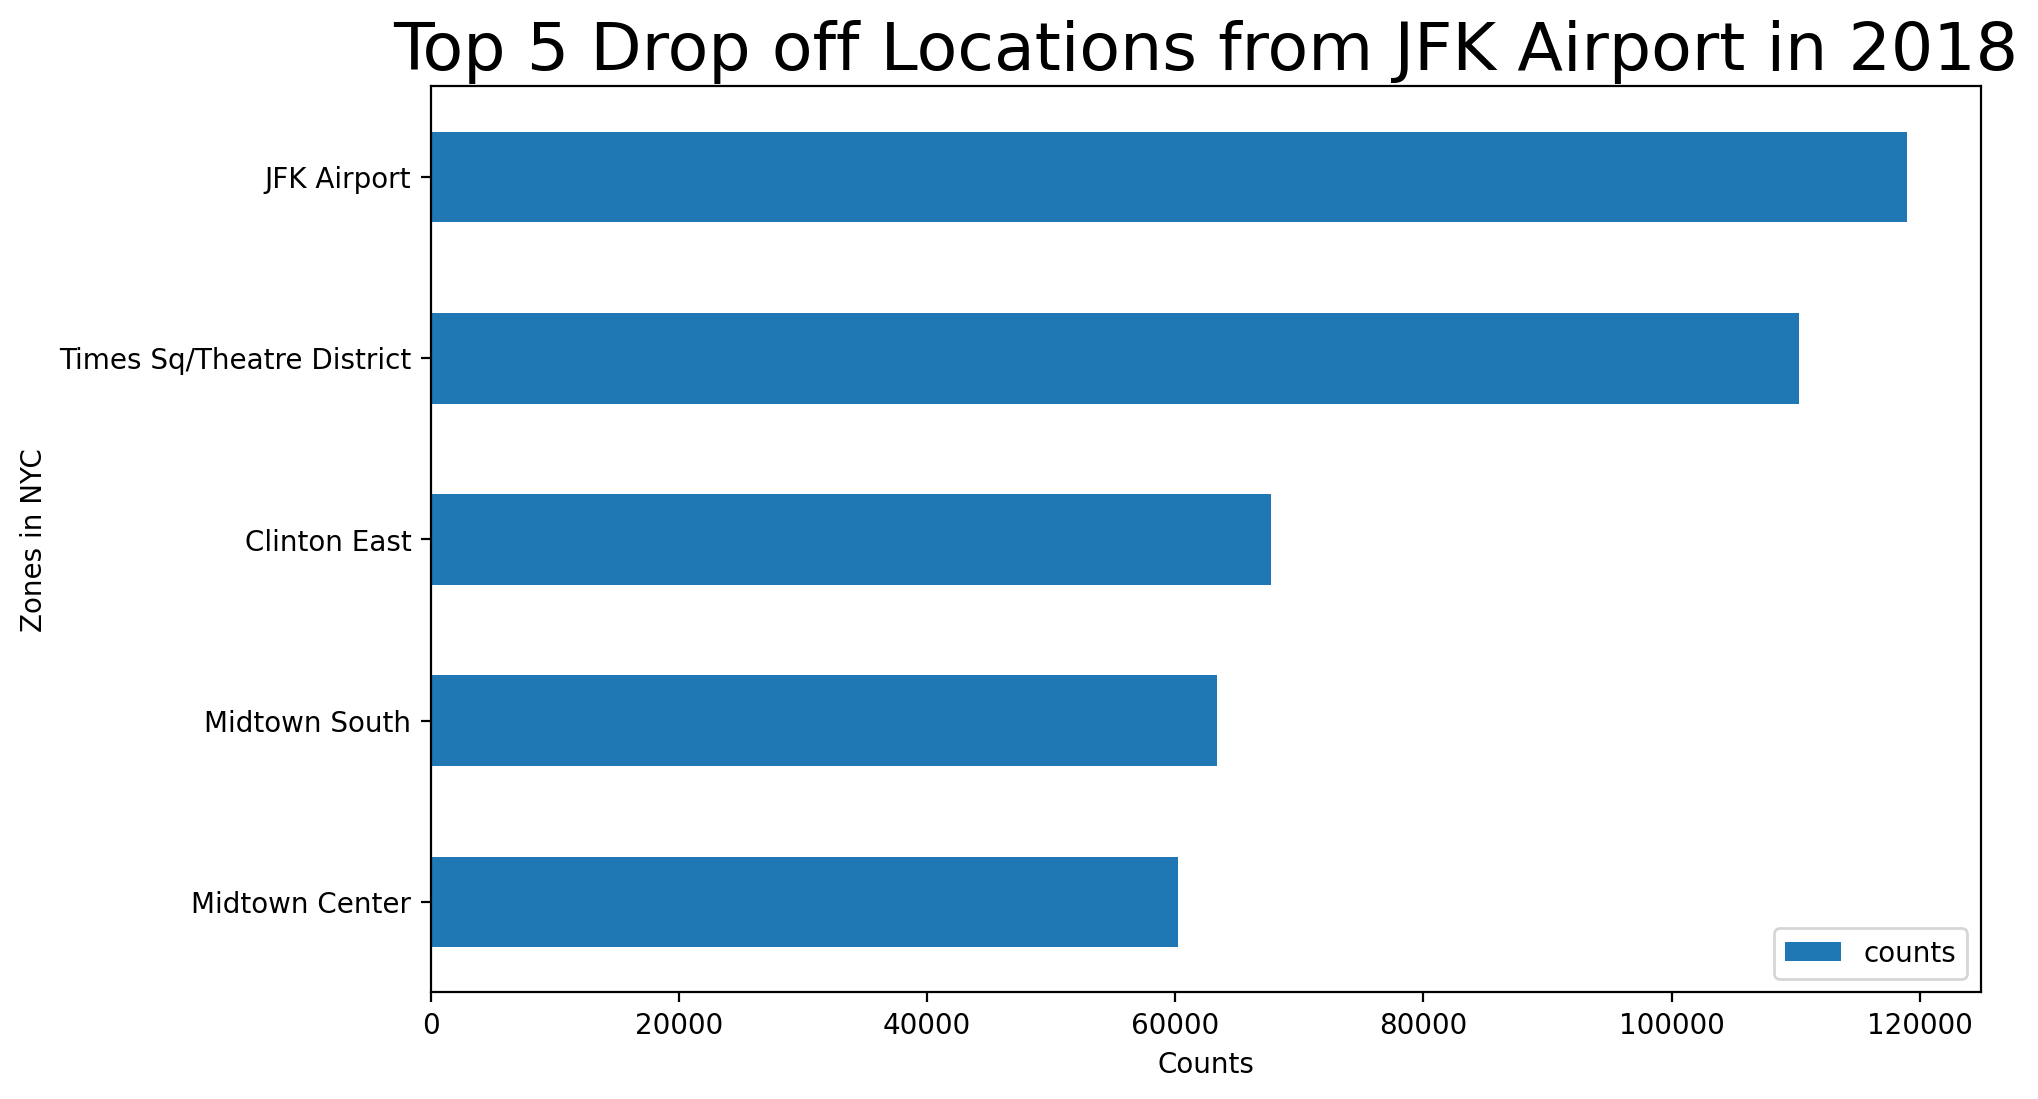

In [10]:
# top 5 drop-off locations from JFK
f, ax = plt.subplots(figsize=(10,6),dpi=200)

# prepare dataframe
top_5_dest = (jfk_by_loc.loc[:,['dropoff_location_id',
                                'counts']]
                        .sort_values('counts',
                                     ascending=False)[0:6])
top_5_dest['dropoff_location_id'] = (top_5_dest['dropoff_location_id'].map(geo.set_index('zone_id')
                                                                              .to_dict()['zone_name']))
top_5_dest = top_5_dest.drop([257]).set_index('dropoff_location_id')

# plot barplot
top_5_dest[::-1].plot.barh(ax=ax)
plt.title('Top 5 Drop off Locations from JFK Airport in 2018', 
                fontsize=24)
plt.ylabel('Zones in NYC')
plt.xlabel('Counts')
plt.show()

From the geomap, we see that the most common drop off locations of NYC taxis 2018 are quite far from the point of origin (JFK airport). The top zone visited right after landing is Times Sq./Theatre District.

New York is known to be a gold mine for tourists - and most go to New York to see a Broadway show or visit the ver famous Times Sq. Thus, it makes sense that this zone is the most popular drop-off since this zone has loads of activities tourists can visit.

The next three zones contain the more famous hotels in NYC: Clinton East (Hilton Garden and Holiday Inn), Midtown South (Hyatt and InterContinental), and Midtown Center (Hilton Garden, The Langham).

This project will delve deeper into taxi passengers activity in the Times Sq. Theatre District since these are highly likely to be New York tourists to see a Broadway show or Times Sq.

## Timeseries

In [11]:
# define function to creat time series plots
def plot_timeseries(grouped,
                    title,
                    agg_dict,
                    ylab,
                    seasons=None):
    # initial view of total fares
    f, ax = plt.subplots(figsize=(18,6),dpi=200)
    plt.suptitle(title, 
                fontsize=24)

    # define series
    total_by_time = pd.DataFrame(grouped.agg(agg_dict)
                                ).sort_index()
    # mean and std
    time_mean = total_by_time.mean()[0]
    time_std = total_by_time.std()[0]

    total_by_time.plot(ax=ax,
                    rot=45,
                    xlabel='DateTime',
                    ylabel=ylab)
    # plot mean and std
    for val, num in enumerate([time_mean,
                            time_mean+time_std,
                            time_mean-time_std]):
        col = ['r','gray','gray'][val]
        lab = ['mean','mean±sd','_nolegend_'][val]
        ax.axhline(y=num, 
                   color=col, 
                   linestyle='--',
                   label=lab)
    # plot seasons if input
    if seasons is not None:
        for xc in seasons:
                ax.axvline(x=xc, 
                           color='black', 
                           linestyle='--')
    plt.legend(loc='upper right')
    plt.show()

# get all dates of a day in a year
def alldays(year, whichDayYouWant):
    # set list for dates
    season_dates = []
    # get day number
    day_ind = dict(zip(['M','T','W','Th','F','Sat','Sun'],
                        range(0,8)))
    d = date(year, 1, 1)
    d += timedelta(days = (day_ind[whichDayYouWant] - d.weekday()) % 7)
    while d.year == year:
        season_dates.append(d)
        d += timedelta(days = 7)
    return season_dates

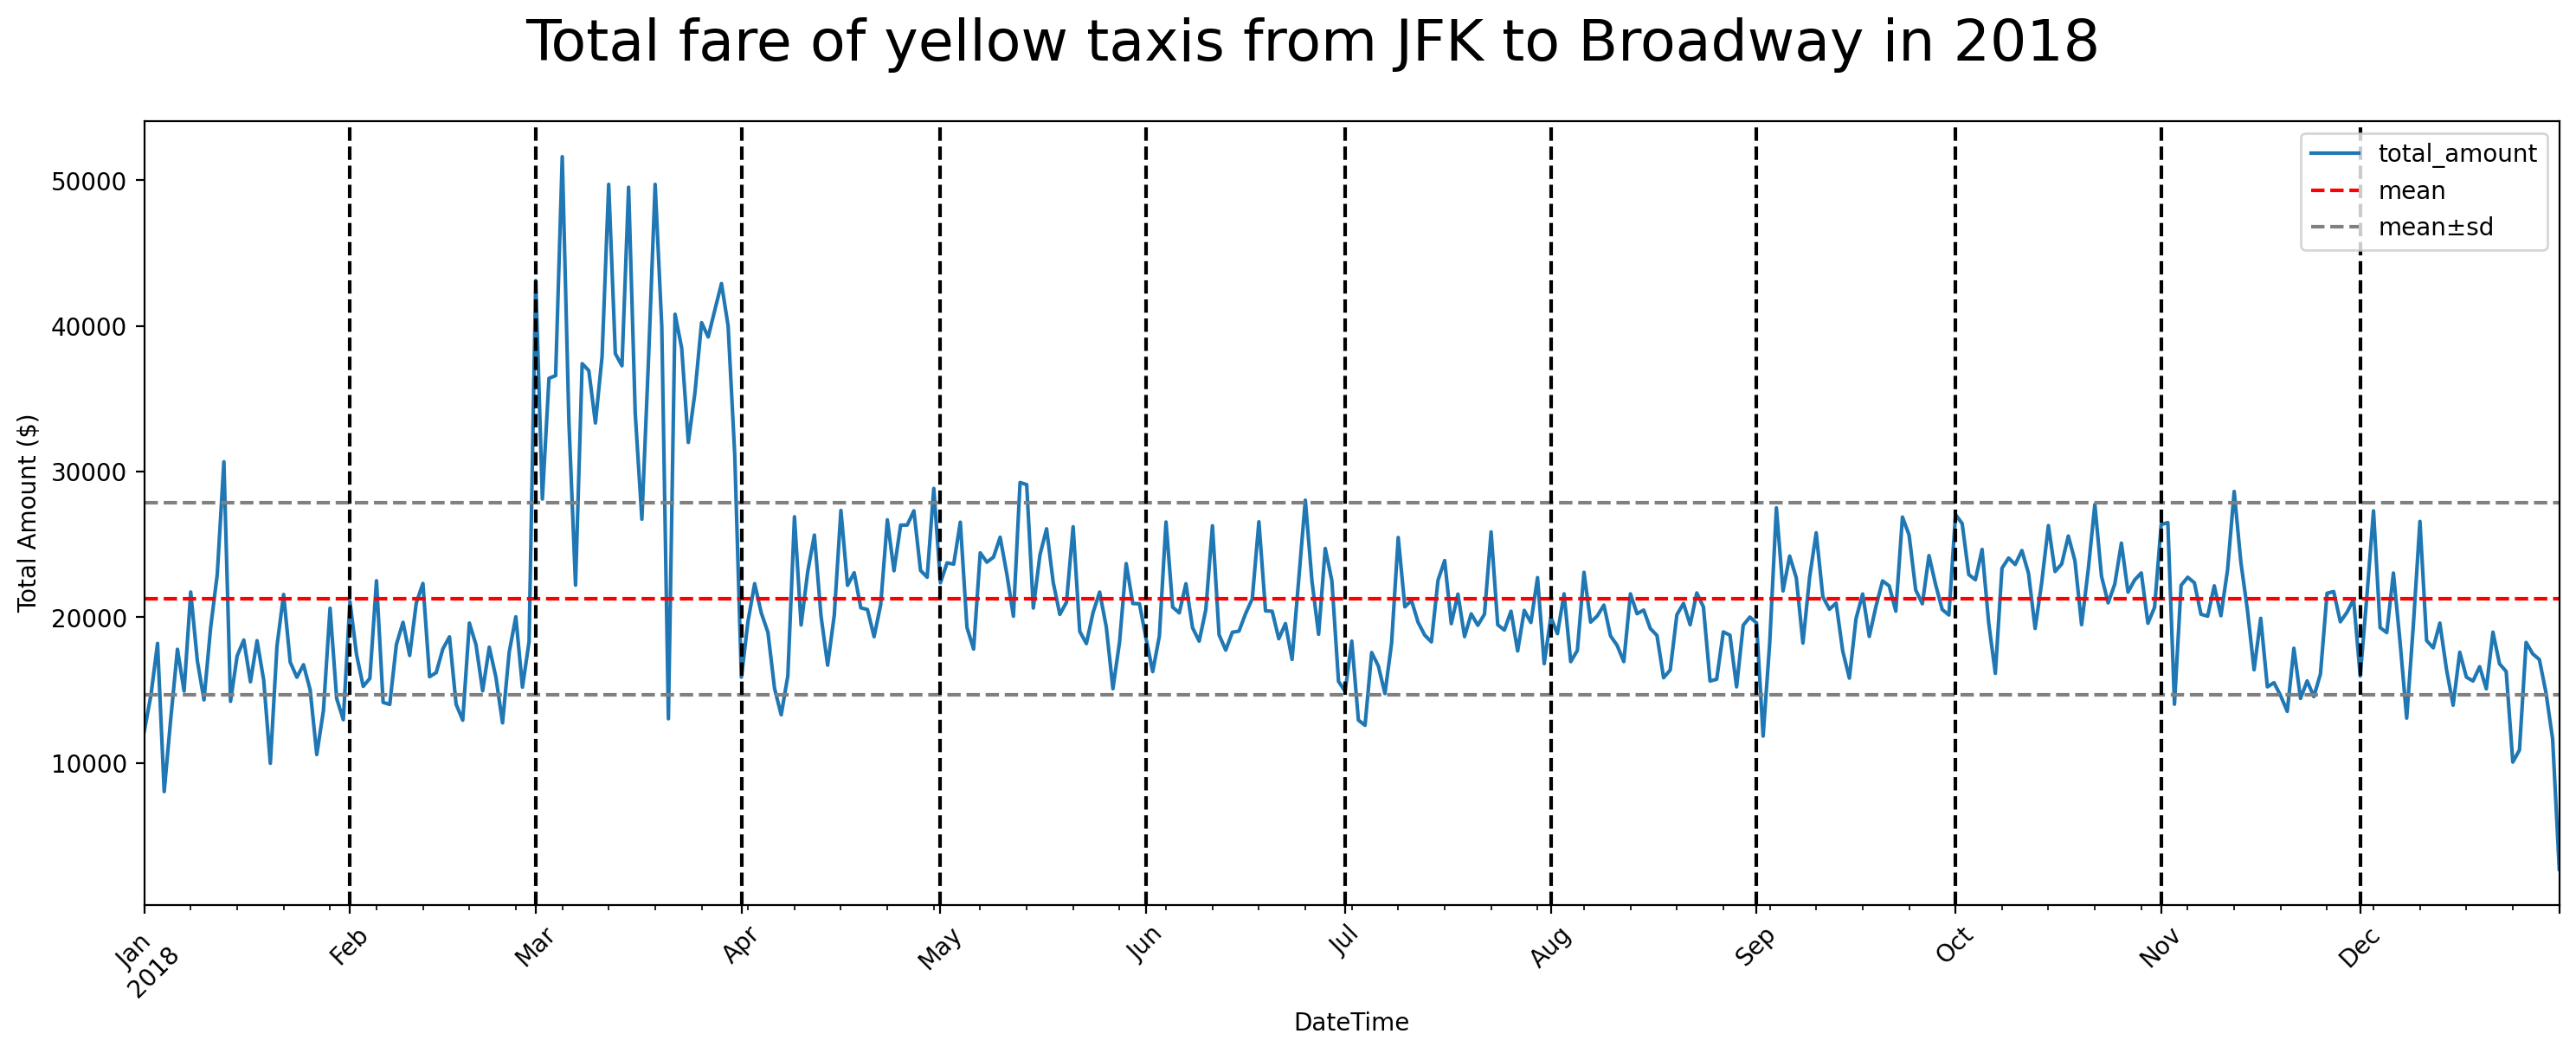

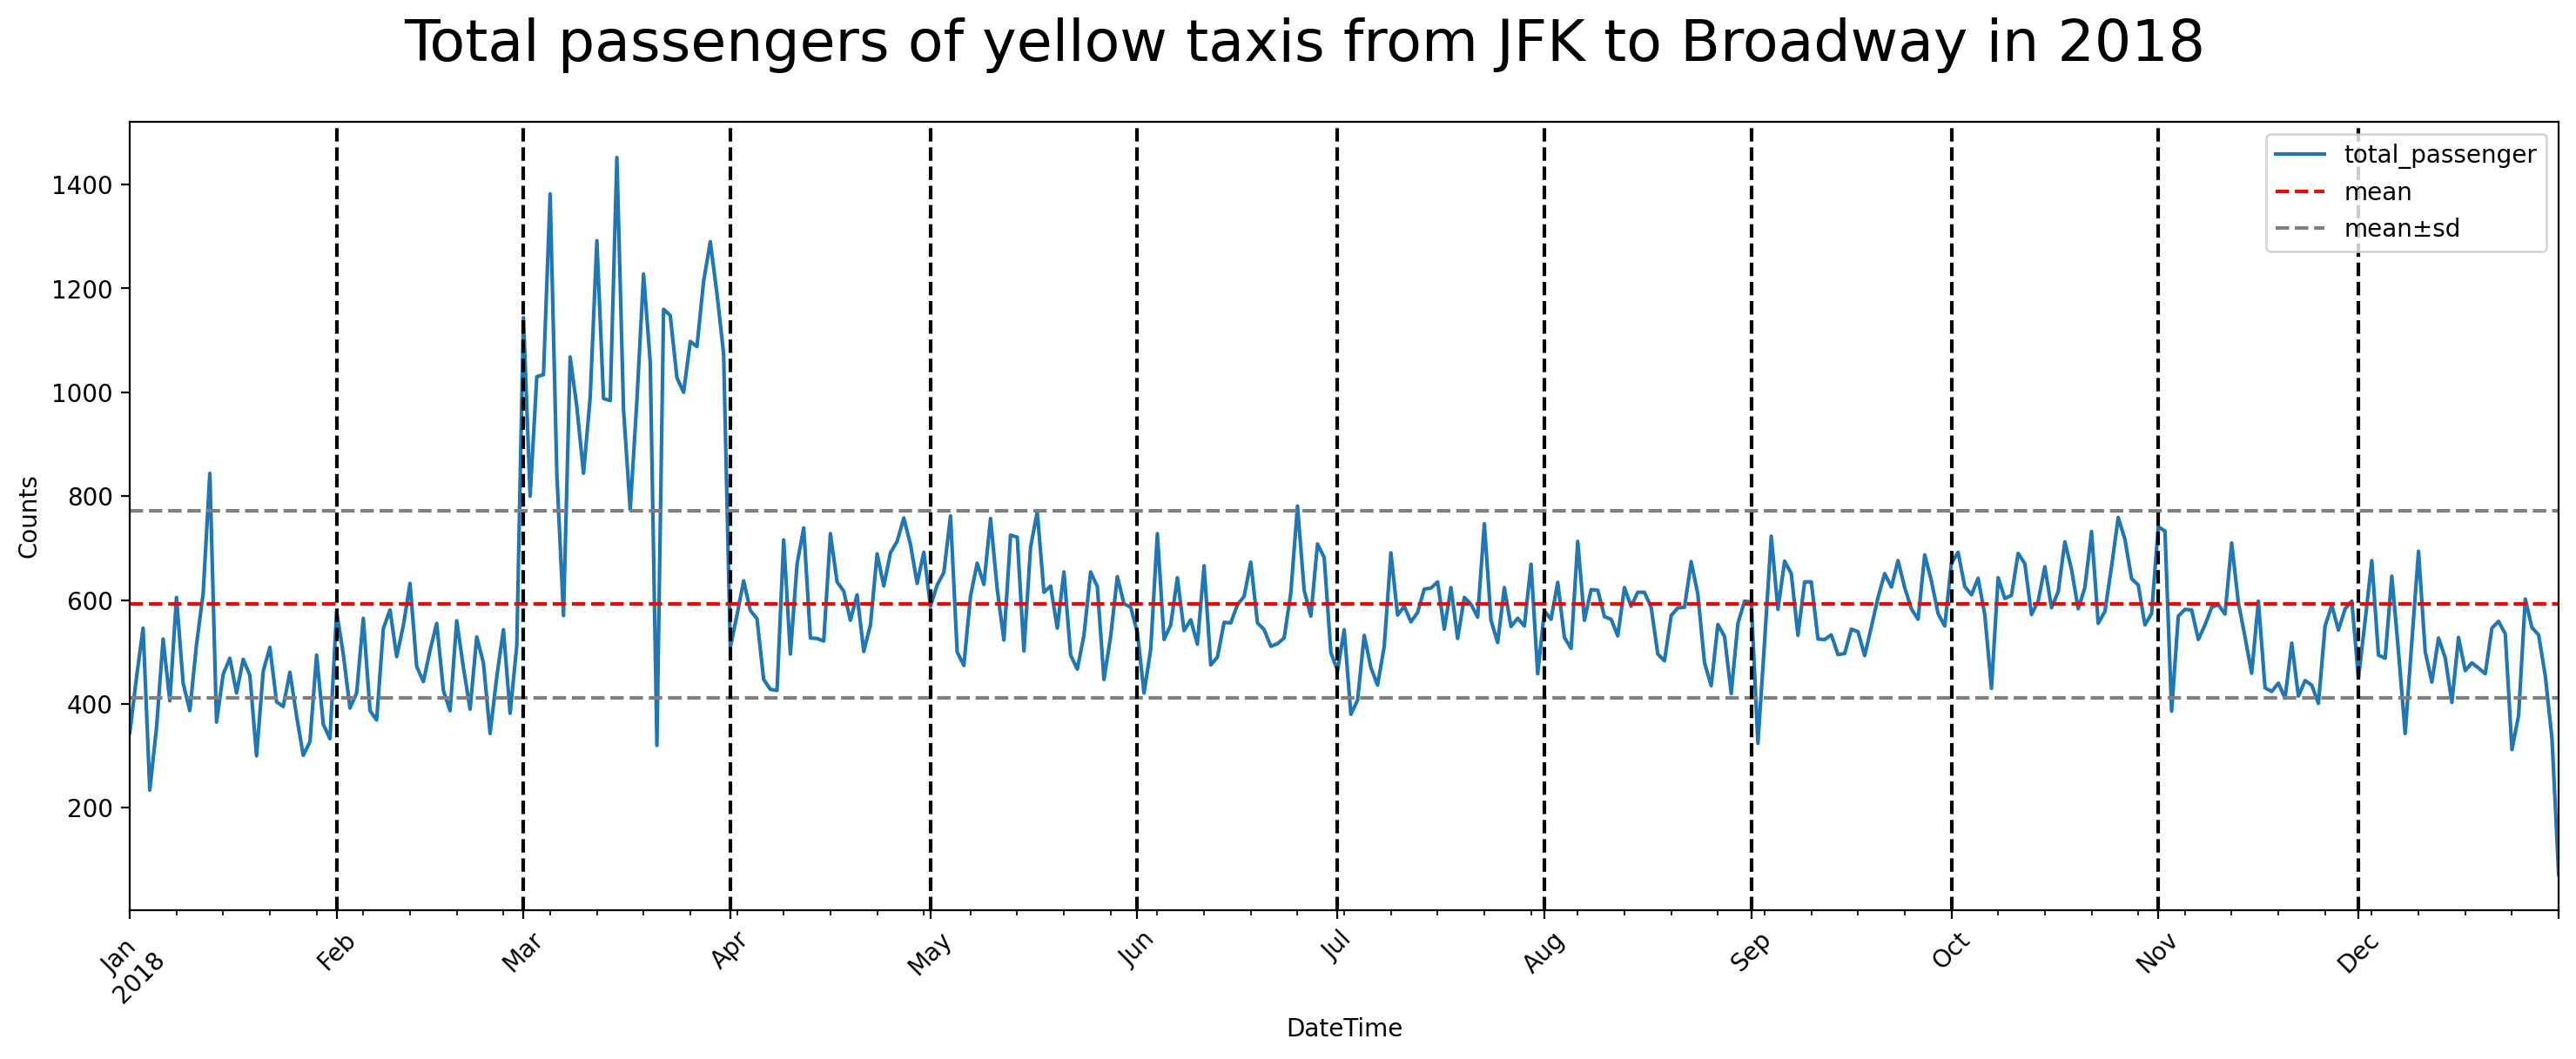

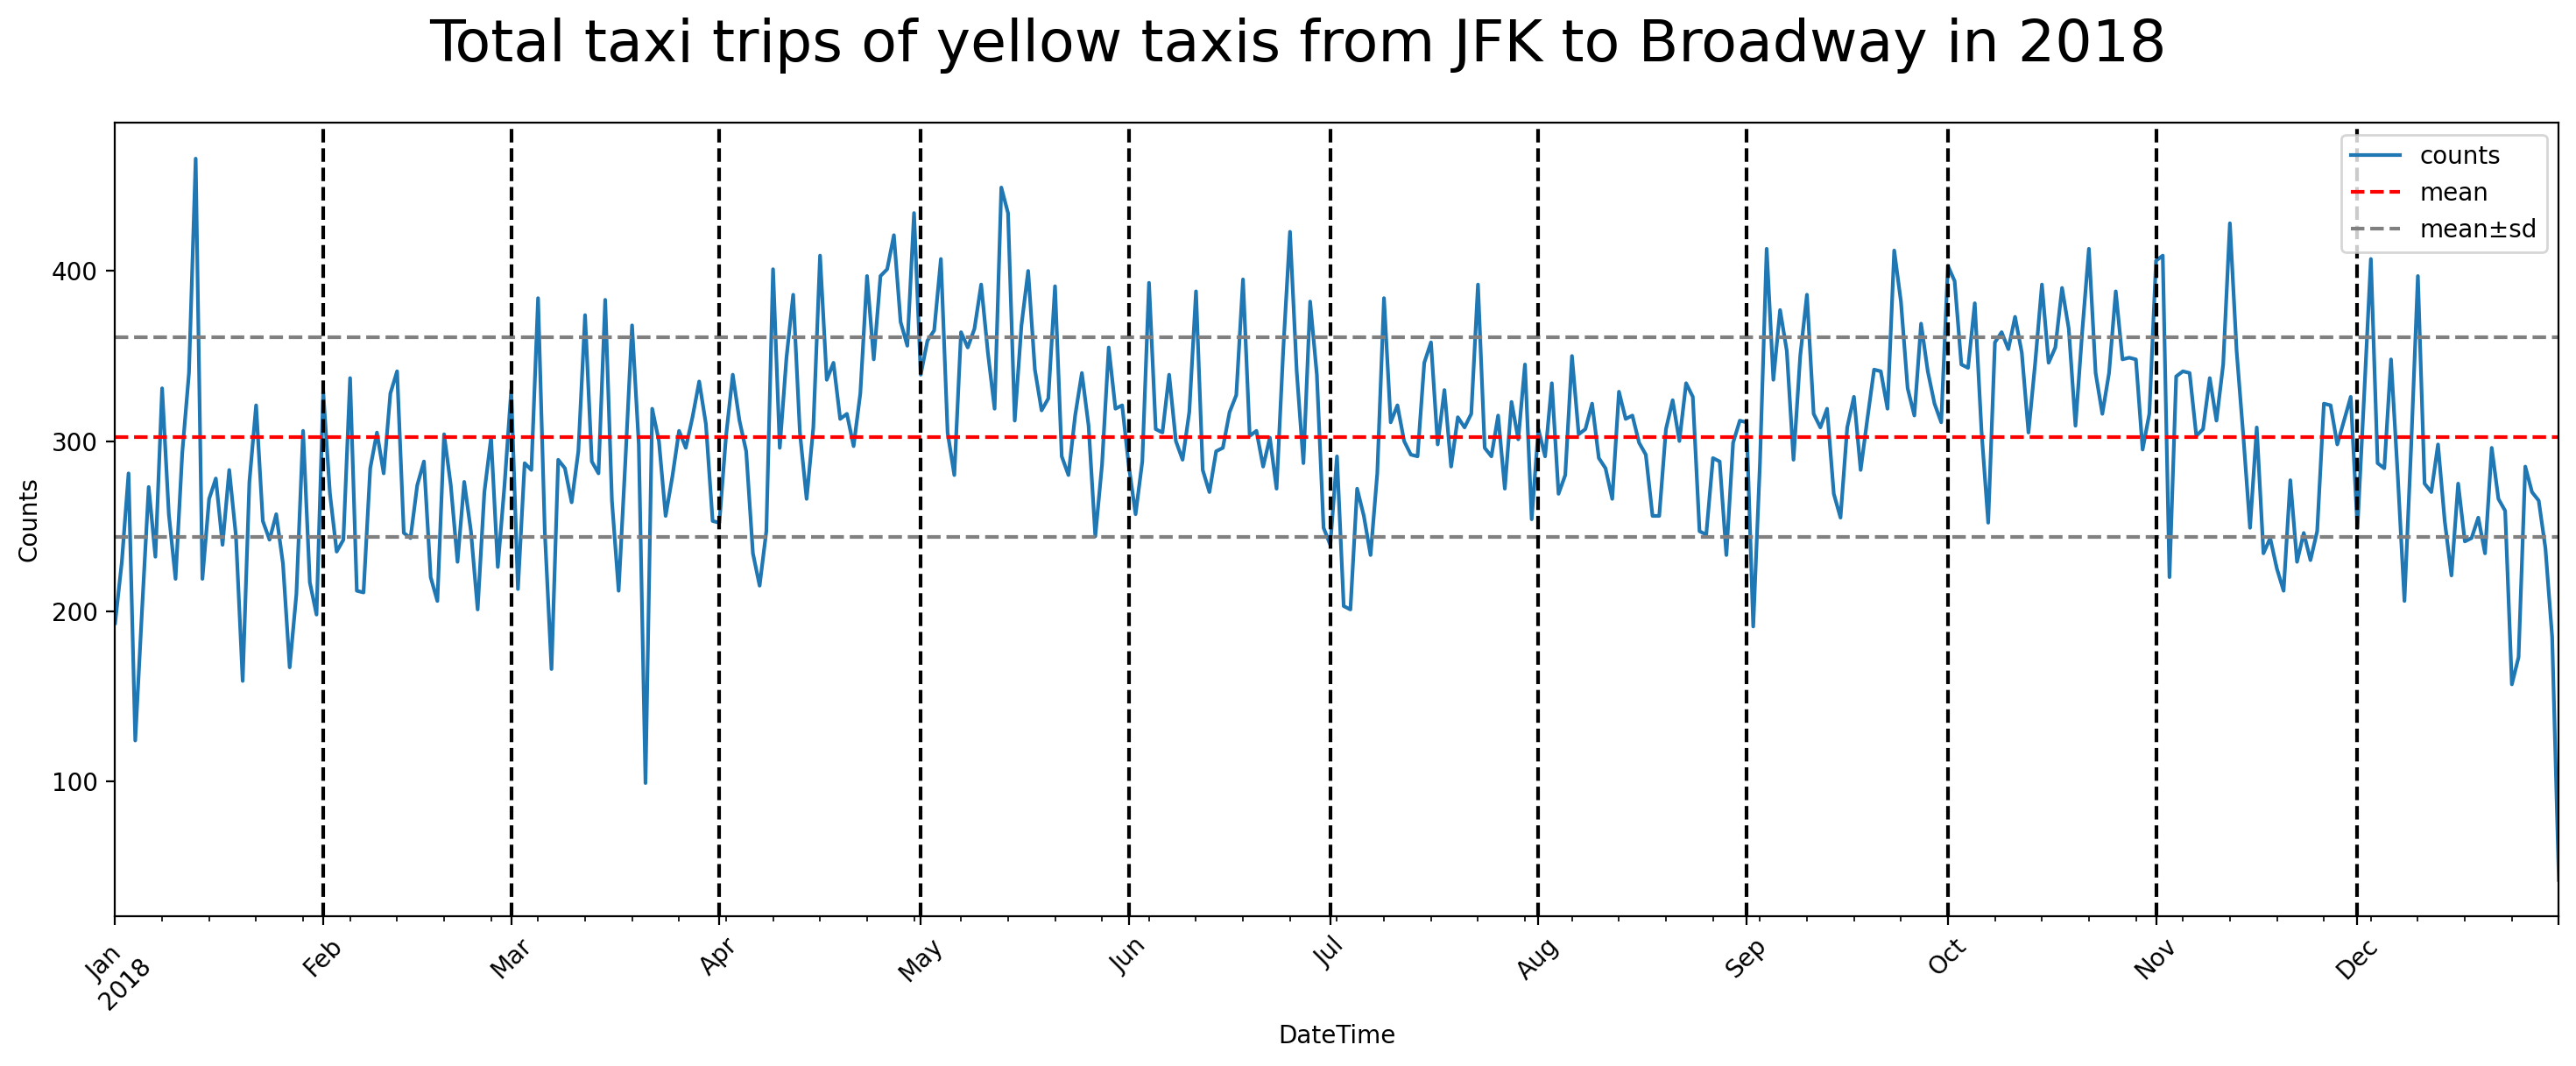

In [12]:
# define start of months
season_date = [f'2018-0{month}-01' if month<10 
            else f'2018-{month}-01' 
            for month in range(2,13)]
season_date = dates.datestr2num(season_date)

# plot time serieses for 2018 JFK to Broadway
for val,groups in enumerate(['total_amount','total_passenger','counts']):
    # define title and y label
    name = ['fare','passengers','taxi trips'][val]
    ylab = ['Total Amount ($)','Counts','Counts'][val]
    # plot timeseries using summarized dataframe
    plot_timeseries(broadway_2018.groupby('date'),
                    f'Total {name} of yellow taxis from JFK to Broadway in 2018',
                    {groups:'sum'},
                    ylab=ylab,
                    seasons=season_date)

In order to investigate the tourist activity in the Broadway district, I used a time series analysis to determine the peak and trough periods in 2018 using taxi trips from JFK Airport to Times/Broadway.

Ideally, it's best to visit New York in the summer (July-Aug) for great weather, or during winter (Nov-Dec) for all the Christmas/New Year celebrations New York is famous for (Rockefeller center ice rink, ball drop on New Year's). These were the expected peak periods. However, from the total number of passengers and total taxi fare earned per day, we see that the peak period is in March.

This is slightly counterintuitive since the weather in New York is unpredictable since March is the month of seasonal transition. This in theory should make this a trough tourist month. However, this may be the very reason why more visitors came into New York from the Airport to the Broadway district. Since prices are lower in March, tourists get to save money on accomodations.

We also see that February (and August) 2018 had the lowest traffic period from the airport to the broadway district.

Another interesting observation is the total taxi trips has a more stable pattern over the year. This slightly goes against the notion that the number of taxi trips directly correspond to the number of passengers going into the area.

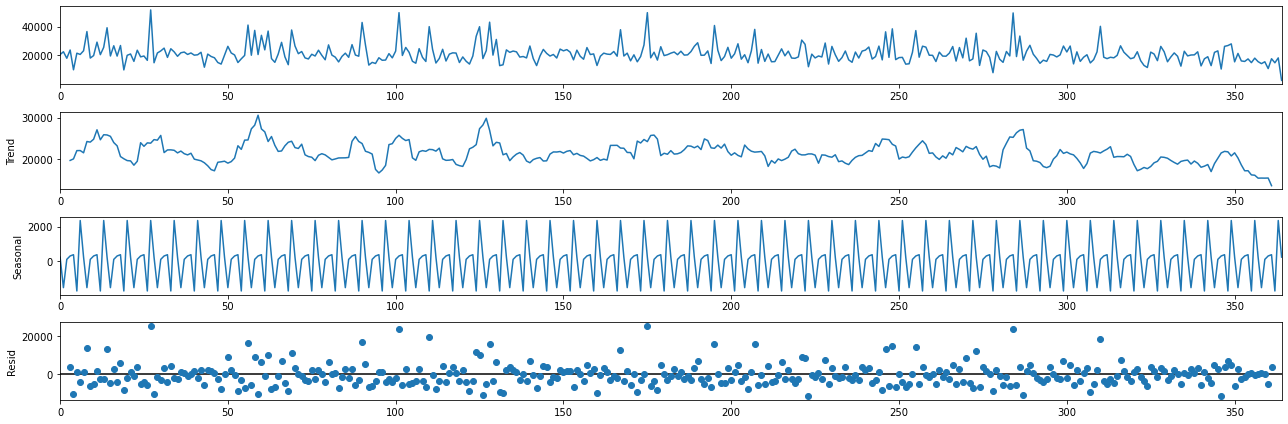

In [13]:
# seasonality of fares
plt.rc("figure", figsize=(18,6))

# slice series for analysis
analysis = broadway_2018[['total_amount']].copy()

# decompose for trends
decompose_result_mult = seasonal_decompose(analysis, 
                                           model="additive",
                                           period=7)
# breakdown 
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

# show plot
decompose_result_mult.plot()
plt.show()

From the decomposition plot, we see that there is a weekly seasonality with the taxi activity.

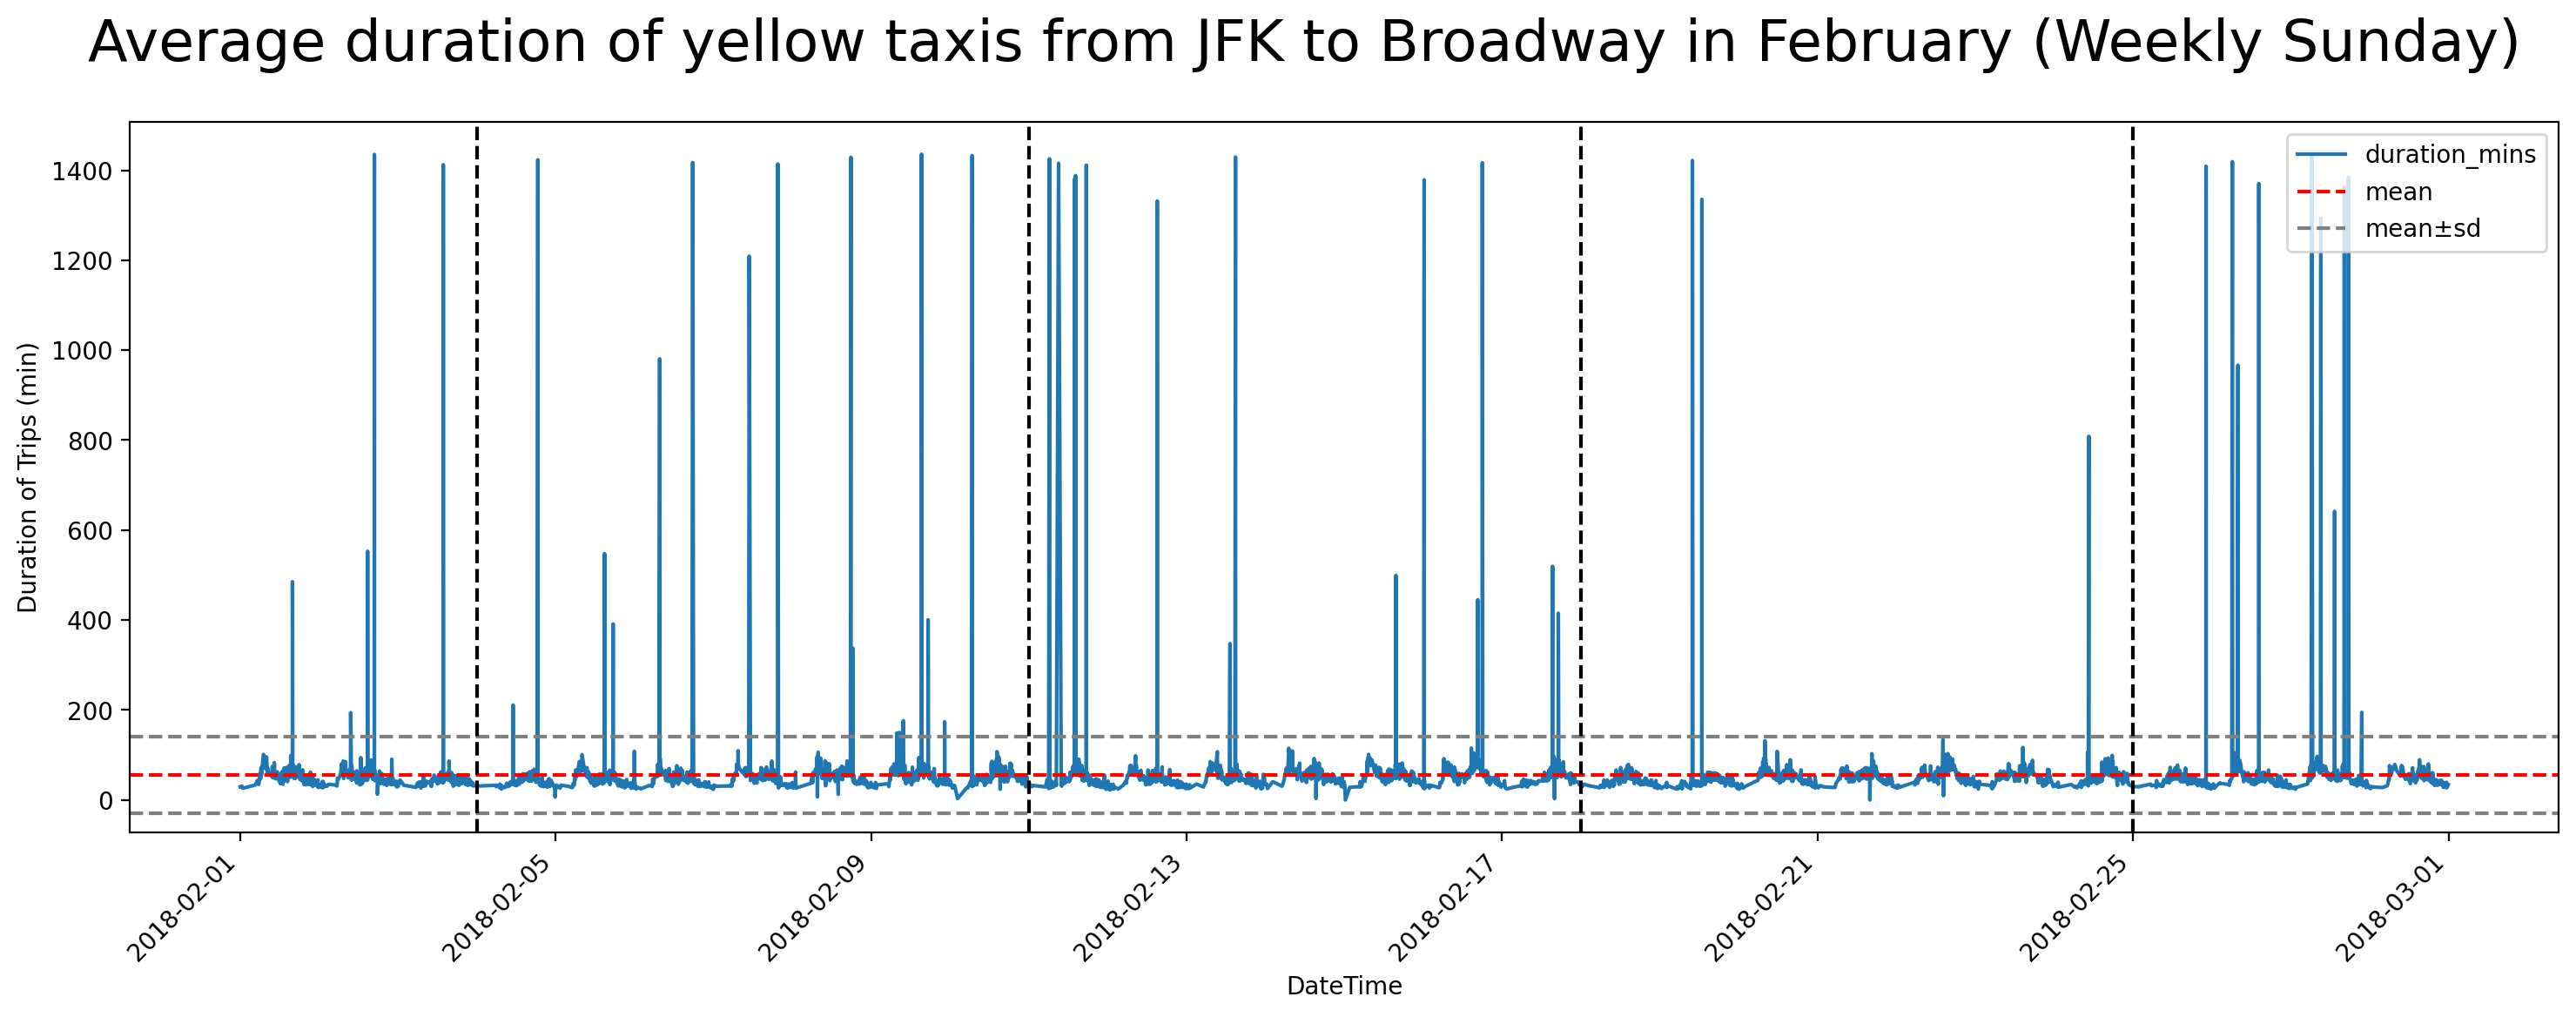

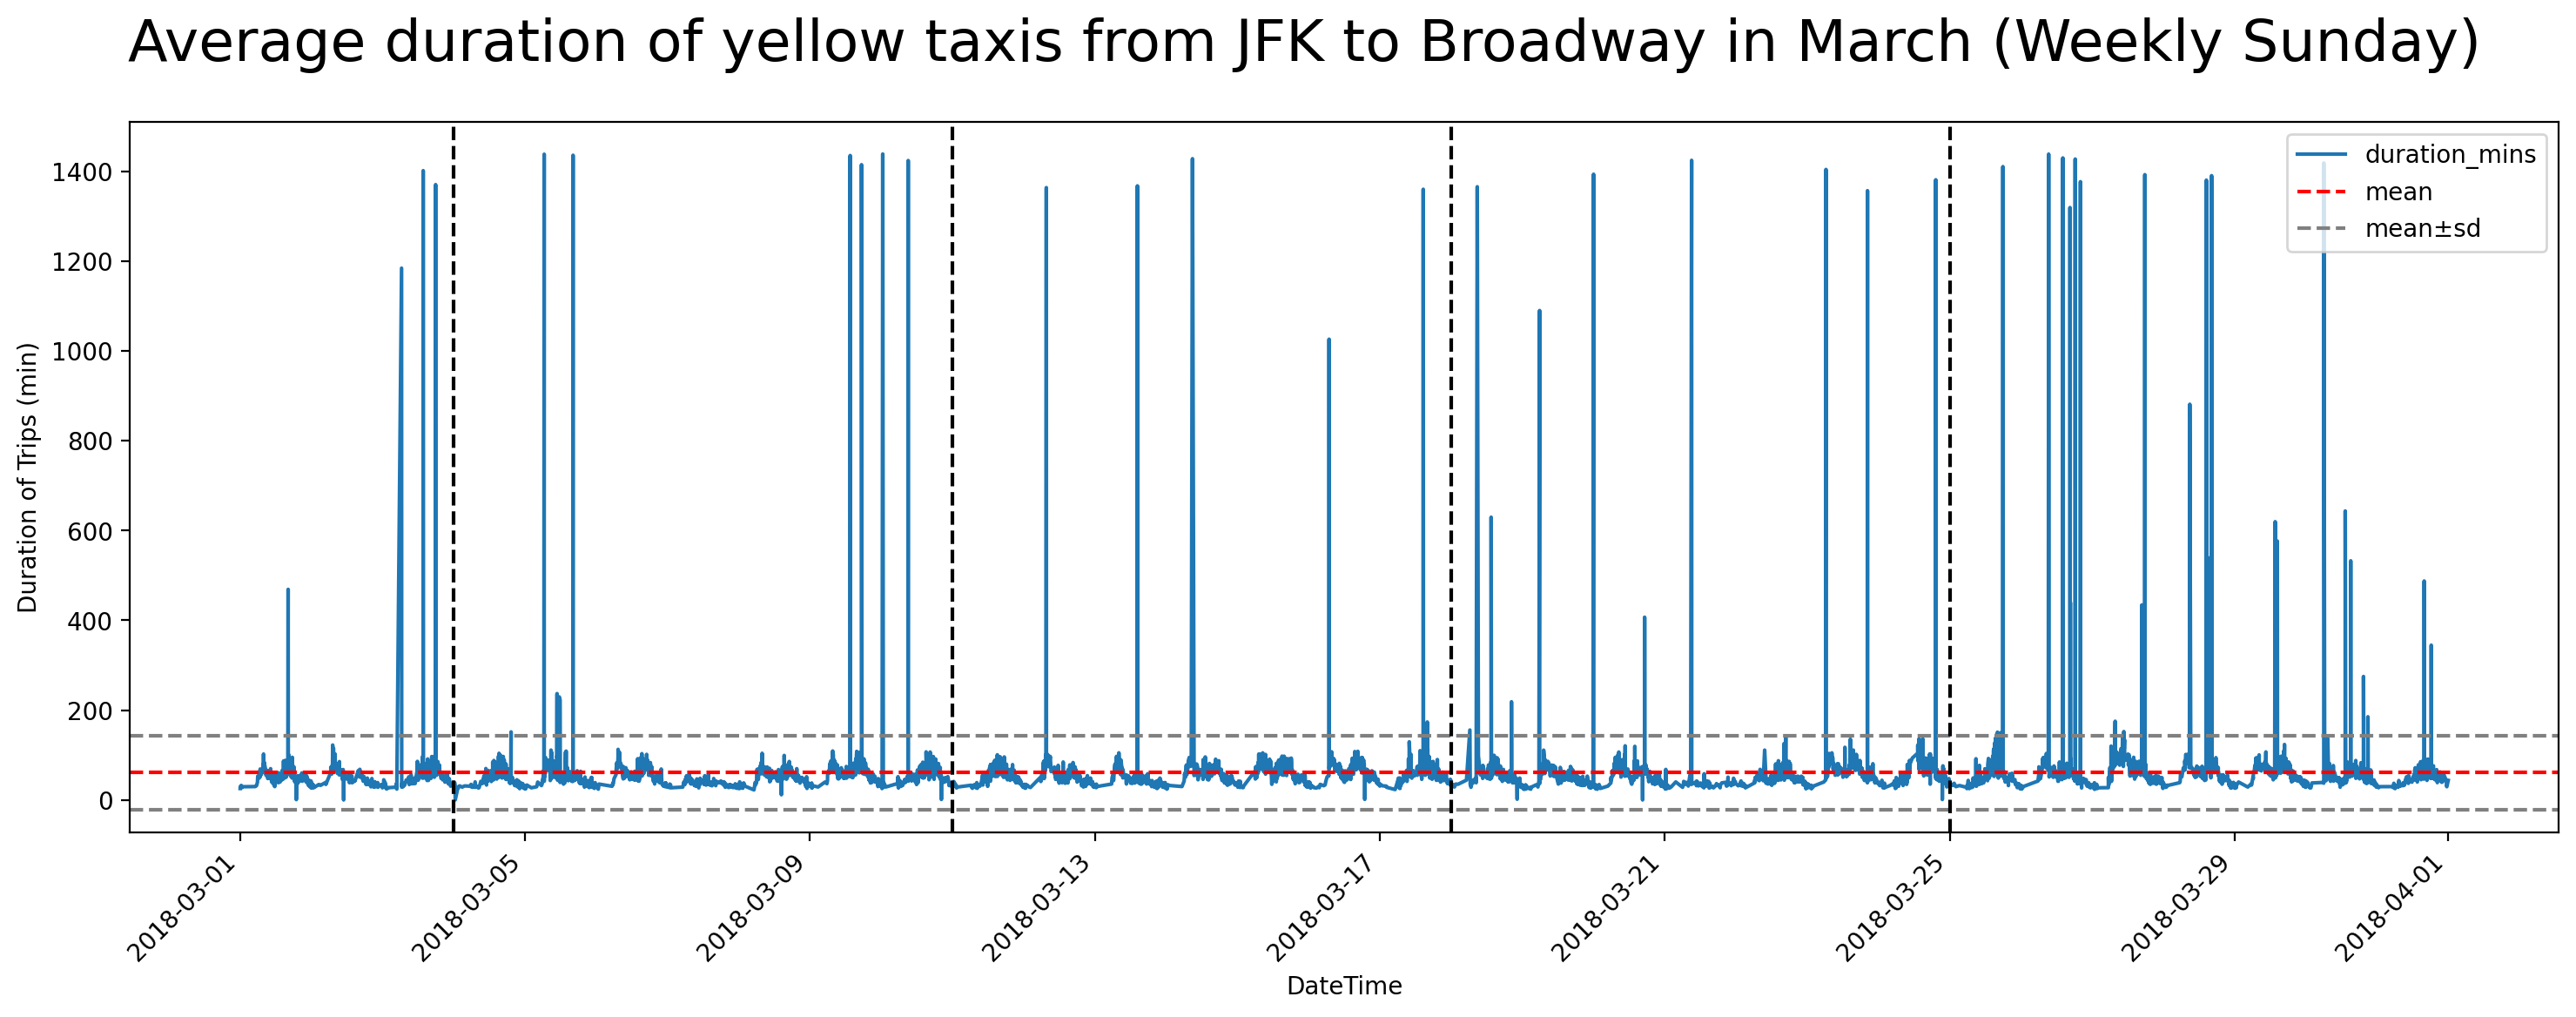

In [14]:
# time series of peak season (march)
for val, month in enumerate([2,3]):
    # define vars and dataset
    season = [i for i in alldays(2018,'Sun') if i.month == month]
    Mon = ['February','March'][val]
    df = [broadway_low_feb,broadway_cluster_march][val]
    # plot timeseries
    plot_timeseries(df.groupby('pickup_datetime'),
                        f'Average duration of yellow taxis from JFK to Broadway in {Mon} (Weekly Sunday)',
                        {'duration_mins':'mean'},
                        ylab='Duration of Trips (min)',
                        seasons=season)

Analyzing the average duration of taxi rides in the peak and trough months in 2018, we see that there is little difference between the two plots. This implies that traffic in NYC is as reliable as traffic in Manila. We see that there are typically more traffic (higher average duration) towards the latter end of the weeks. We also see that traffic starts to build even more towards the end of the months. If tourists would like to visit NYC in March, it's best to go early March to avoid the longer taxi rides and probably find other modes of transportation during weekends (unless they're willing to spend almost a whole day in a taxi).

## Clustering

In [15]:
# time of day
# categories
b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Evening','Night']

for col in ['pickup','dropoff']:
    # extract hour
    broadway_cluster_march[f'{col}_time_hour'] = broadway_cluster_march[f'{col}_datetime'].dt.hour
    # cut and categorize
    broadway_cluster_march[f'{col}_timecat'] = pd.cut(broadway_cluster_march[f'{col}_time_hour'],
                                                      bins=b, 
                                                      labels=l, 
                                                      include_lowest=True)
            

In [16]:
# remove trips with no payment
broadway_cluster_march = broadway_cluster_march[broadway_cluster_march.total_amount>0]

# get interesting columns for clustering
clustering = broadway_cluster_march.loc[:,['passenger_count',
                                           'trip_distance',
                                           'rate_code',
                                           'tip_percent',
                                           'duration_mins',
                                           'pickup_time_hour']]
# one hot encode category
# clustering['pickup_timecat'] = pd.get_dummies(clustering.pickup_timecat)

# fill NaNs with 0
clustering = clustering.fillna(0)

In [17]:
clustering.head()

passenger_count  trip_distance  rate_code  tip_percent  duration_mins  \
0                1          17.61          1     0.278276      64.100000   
1                2          18.03          5     0.000000      54.150000   
2                1          17.20          2     0.181923      72.466667   
3                4          18.50          2     0.225000      61.700000   
4                4          18.36          2     0.134615      66.500000   

   pickup_time_hour  
0                14  
1                10  
2                17  
3                11  
4                16

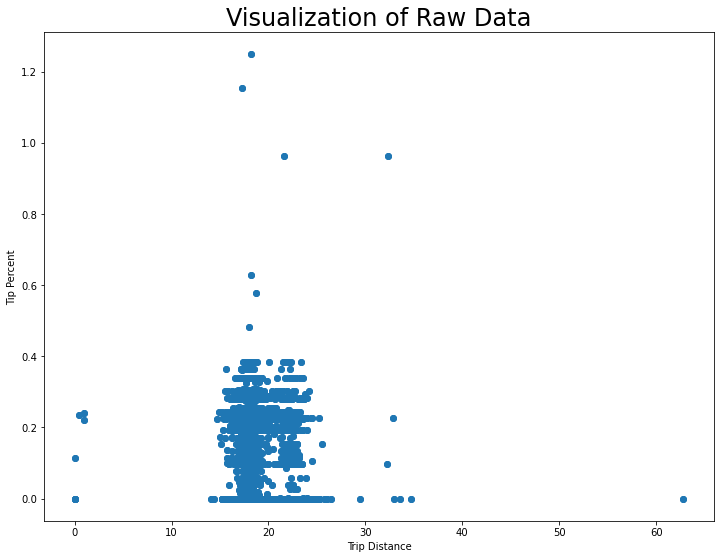

In [18]:
# visualize raw data
plt.figure(figsize=(12,9))
plt.scatter(clustering['trip_distance'],
            clustering['tip_percent'])
plt.xlabel('Trip Distance')
plt.ylabel('Tip Percent')
plt.title('Visualization of Raw Data', 
           fontsize=24)
plt.show()

In [19]:
# standardization
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(clustering)

# PCA
pca = PCA()
pca.fit(segmentation_std)

# explained variance
pca.explained_variance_ratio_

array([0.18354696, 0.17485686, 0.16816601, 0.16631828, 0.15469396,
       0.15241793])

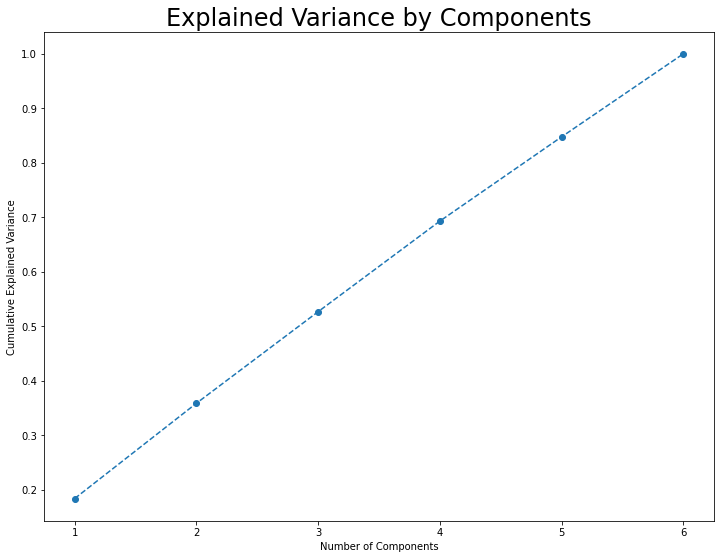

In [20]:
# plot cumulative explained variance from PCA
plt.figure(figsize=(12,9))
plt.plot(range(1,len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o',
         linestyle='--')
plt.title('Explained Variance by Components',
          fontsize=24)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [22]:
# get 4 PCA
pca = PCA(n_components=4)
# fit model
pca.fit(segmentation_std)
# save scores
scores_pca = pca.transform(segmentation_std)

#### K-Means

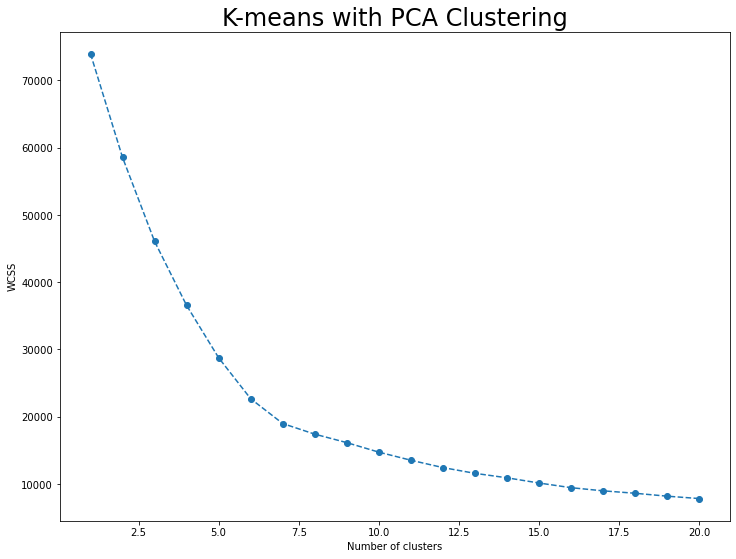

In [23]:
# determine number of clusters
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters=i,
                        init='k-means++',
                        random_state=2021)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

# plot wcss
plt.figure(figsize=(12,9))
plt.plot(range(1,21),
         wcss,
         marker='o',
         linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering',
          fontsize=24)
plt.show()

In [24]:
# inflection point at 7 clusters
kmeans_pca = KMeans(n_clusters=7,
                    init='k-means++',
                    random_state=2021)

# fit scores
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=7, random_state=2021)

In [25]:
# add cluster IDs
clustering_id = pd.concat([clustering.reset_index(drop=True),
                           pd.DataFrame(scores_pca)],
                           axis=1)
clustering_id.columns.values[-4:] = [f'PCA_{i}' for i in range(1,5)]
clustering_id['cluster_id'] = kmeans_pca.labels_

# view dataframe
clustering_id.head()

passenger_count  trip_distance  rate_code  tip_percent  duration_mins  \
0                1          17.61          1     0.278276      64.100000   
1                2          18.03          5     0.000000      54.150000   
2                1          17.20          2     0.181923      72.466667   
3                4          18.50          2     0.225000      61.700000   
4                4          18.36          2     0.134615      66.500000   

   pickup_time_hour     PCA_1     PCA_2     PCA_3      PCA_4  cluster_id  
0                14 -2.408850 -0.309740  1.423780  -5.625625           4  
1                10  3.956713  3.501940 -4.656469  16.606058           3  
2                17 -0.957637  0.286128  0.068235   0.003419           4  
3                11  0.176867 -0.159808 -0.933351  -0.454736           5  
4                16  0.473815 -0.913986 -0.761737  -0.345448           6

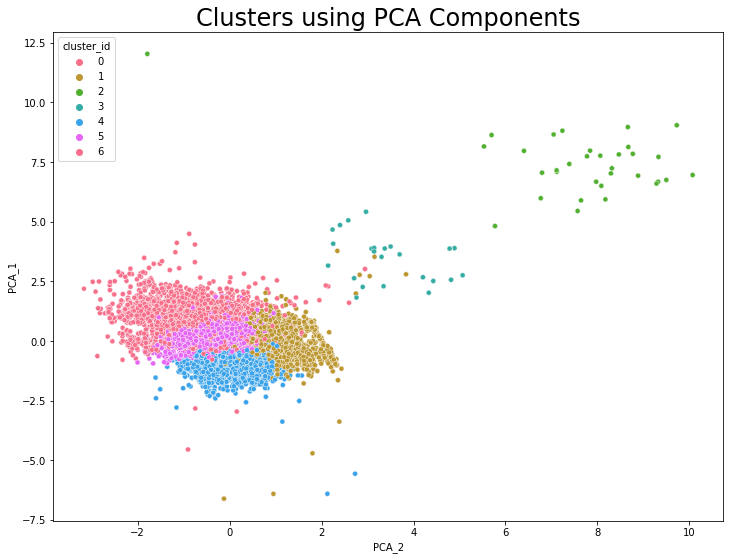

In [26]:
# plot data using first two components
x_axis = clustering_id.PCA_2
y_axis = clustering_id.PCA_1

plt.figure(figsize=(12,9))
sns.scatterplot(x_axis,
                y_axis,
                hue=clustering_id.cluster_id,
                palette='husl',
                s=25)

plt.title('Clusters using PCA Components',
          fontsize=24)
plt.show()

In [27]:
# summarize features per cluster
cluster_summary = clustering_id.groupby('cluster_id').agg({'passenger_count':'mean',
                                                            'trip_distance':'mean',
                                                            'rate_code':'mean',
                                                            'tip_percent':'mean',
                                                            'duration_mins':'mean',
                                                            'pickup_time_hour':pd.Series.mode,
                                                            })
# add count of clusters
cluster_summary['counts'] = clustering_id.groupby('cluster_id').size()
cluster_summary['perc'] = (cluster_summary.counts / cluster_summary.counts.sum()).apply(lambda x:f'{x:.2%}')
# display summary
cluster_summary

passenger_count  trip_distance  rate_code  tip_percent  \
cluster_id                                                           
0                  1.496726      22.229280   1.999065     0.105647   
1                  1.396766      17.878601   1.997512     0.123123   
2                  1.575758      20.000000   2.000000     0.101795   
3                  1.708333      18.177500   5.000000     0.074931   
4                  1.195473      17.987811   1.995885     0.230785   
5                  1.553716      18.167378   1.998845     0.030449   
6                  4.522276      18.322885   1.997353     0.063507   

            duration_mins pickup_time_hour  counts    perc  
cluster_id                                                  
0               63.827206               17    2138  12.02%  
1               55.730514                7    3216  18.08%  
2             1318.971212                6      66   0.37%  
3               64.964583         [15, 16]      48   0.27%  
4               51.521907               16    4860  27.32%  
5               57.314889               14    5194  29.20%  
6               56.977717               16    2267  12.74%

These clusters divide the Broadway visitors (straight from JFK airport) into 7 groups.

```
C0 (Late Afternoon Low Tipper): Late afternoon, mid-long ride, single passenger, low tippers
C1 (Early Morning Short Ride): Early morning, short ride, single passenger
C2 (Early Morning Long Rides): Early morning, very-long rides
C3 (Afternoon High Raters): Afternoon, long ride, double passengers, high rater
C4 (Afternoon Low Tippers): Afternoon, short distance, single passenger, very-low tipper
C5 (Early Afternoon Short Ride): Early afternoon, shorter distance, low tippers
C6 (Multiple Passengers): Afternoon, multiple passengers, low tippers
```

Most of these groups have similar characteristics, but the most stand-out clusters are C2, C3, C6. Most of the tourists fall under cluster C5 which are the early afternoon short riders. This means it's advisable for tourists who wish to visit NYC in March to catch a flight that lands at around 2PM for a higher chance of getting a cab (that's also liekly to be a shorter cab right).

In [28]:
# # spider diagrams
# angles = np.linspace(0,
#                      2*np.pi,
#                      6,
#                      endpoint=False)


#### DBSCAN

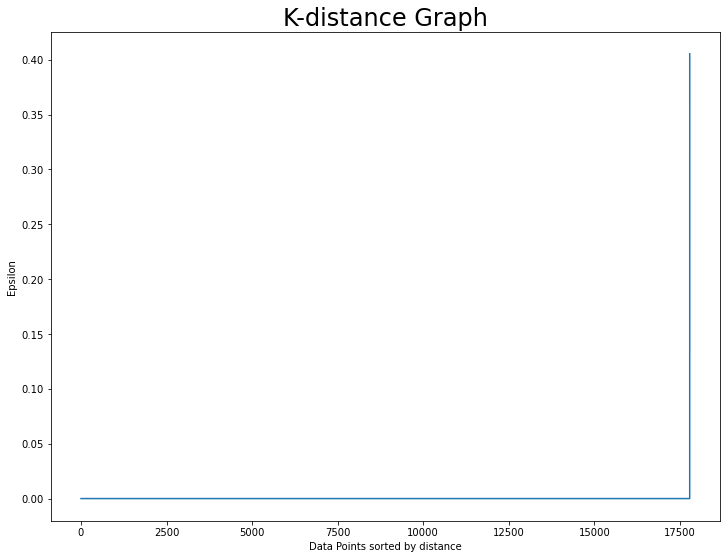

In [29]:
# determine optimum epsilon
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(scores_pca)
distances, indices = nbrs.kneighbors(scores_pca)

# plotting k-distance graph
distances = np.sort(distances,axis=0)
distances = distances[:,1]
plt.figure(figsize=(12,9))
plt.plot(distances)
plt.title('K-distance Graph',
          fontsize=24)
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.show()

In [30]:
dbscan = DBSCAN()
dbscan.fit(scores_pca)

DBSCAN()